<a href="https://colab.research.google.com/github/vishnudas-raveendran/AI_RL_Python/blob/master/Capstone_interim_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interim Submission - Capstone

In [1]:
!pip install textacy

     |████████████████████████████████| 200 kB 5.2 MB/s 
     |████████████████████████████████| 2.0 MB 68.8 MB/s 
     |████████████████████████████████| 481 kB 77.3 MB/s 
     |████████████████████████████████| 132 kB 59.9 MB/s 
     |████████████████████████████████| 6.0 MB 44.1 MB/s 
     |████████████████████████████████| 181 kB 64.7 MB/s 
     |████████████████████████████████| 628 kB 56.8 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 451 kB 78.7 MB/s 
     |████████████████████████████████| 10.1 MB 48.0 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1230827 sha256=5ad7ea38ec396624c3cbc3659db53a4c66b924d92c063a56f6b1360c0a25c81a
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73967 sha256=92ec87a8d4774a12eb7e8eed9aca23de109019e568b5df0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textacy
import spacy

In [229]:
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import warnings
import logging
logging.basicConfig(level=logging.INFO)
from keras.constraints import unit_norm
from tensorflow.keras.optimizers import SGD

In [3]:
print(spacy.__version__)

3.2.3


In [4]:
## Load English models
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     |████████████████████████████████| 13.9 MB 4.2 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
!unzip archive.zip -d data

Archive:  archive.zip
  inflating: data/Accidents_Storyline_example.png  
  inflating: data/IHMStefanini_industrial_safety_and_health_database.csv  
  inflating: data/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv  


## 1. Import Dataset

In [8]:
data = pd.read_csv("data/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv")

In [9]:
data.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [10]:
data.shape

(425, 11)

## 2. Pre-Process Dataset

### 2.1 Rename columns suitably

In [11]:
data.drop("Unnamed: 0", axis=1, inplace=True)

In [12]:
data.rename(columns = {'Data':'Date'}, inplace = True)

In [13]:
data.rename(columns={'Genre':'Gender'}, inplace=True)

In [14]:
data.rename(columns={'Employee or Third Party':'Employee_Third_Party'}, inplace=True)

In [15]:
cols = data.columns
print(cols)

Index(['Date', 'Countries', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee_Third_Party',
       'Critical Risk', 'Description'],
      dtype='object')


### 2.2 Check for null values

In [16]:
#Check for null values
pd.DataFrame(data.isnull().sum(), columns=['No. of missing values'])

,No. of missing values
Date,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Gender,0
Employee_Third_Party,0
Critical Risk,0
Description,0


### 2.3 Check for duplicates

In [17]:
print(f"There are {data.duplicated().sum()} duplicate rows")

There are 7 duplicate rows


In [18]:
data.drop_duplicates(inplace=True)

In [19]:
data.shape

(418, 10)

### 2.4 Reformat dates to month, week for more insights

In [20]:
data['Date'] = pd.to_datetime(data['Date'])

data['Month'] = data.Date.apply(lambda x : x.month)
data['Day'] = data.Date.apply(lambda x : x.day)
data['Weekday'] = data.Date.apply(lambda x : x.day_name())
data['WeekofYear'] = data.Date.apply(lambda x : x.weekofyear)
data['Year'] = data.Date.apply(lambda x:x.year)

In [21]:
data.head()

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee_Third_Party,Critical Risk,Description,Month,Day,Weekday,WeekofYear,Year
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,1,1,Friday,53,2016
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,1,2,Saturday,53,2016
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,1,6,Wednesday,1,2016
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,1,8,Friday,1,2016
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,1,10,Sunday,1,2016


## 3. Explore Dataset

### 3.1 Get unique values and frequency in all categorical columns

In [22]:
for col in data.columns:
  if not col in ['Unnamed: 0','Date','Description']:
    print(col)
    print("."*40)
    print(data[col].unique())
    print(data[col].value_counts())
    print("\n")

Countries
........................................
['Country_01' 'Country_02' 'Country_03']
Country_01    248
Country_02    129
Country_03     41
Name: Countries, dtype: int64


Local
........................................
['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']
Local_03    89
Local_05    59
Local_01    56
Local_04    55
Local_06    46
Local_10    41
Local_08    27
Local_02    23
Local_07    14
Local_12     4
Local_09     2
Local_11     2
Name: Local, dtype: int64


Industry Sector
........................................
['Mining' 'Metals' 'Others']
Mining    237
Metals    134
Others     47
Name: Industry Sector, dtype: int64


Accident Level
........................................
['I' 'IV' 'III' 'II' 'V']
I      309
II      40
III     31
IV      30
V        8
Name: Accident Level, dtype: int64


Potential Accident Level
........................................
['IV' 'III' 'I' 'II' 'V' '

In [23]:
def assign_seasons(month):
    if month in [9,10,11]:
        season = 'Spring'
    elif month in [1,2,12]:
        season = 'Summer'
    elif month in [3,4,5]:
        season = 'Autumn'
    elif month in[6,7,8]:
        season = 'Winter'
    return season

In [24]:
data['Season'] = data['Month'].apply(assign_seasons)
data.head()

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee_Third_Party,Critical Risk,Description,Month,Day,Weekday,WeekofYear,Year,Season
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,1,1,Friday,53,2016,Summer
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,1,2,Saturday,53,2016,Summer
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,1,6,Wednesday,1,2016,Summer
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,1,8,Friday,1,2016,Summer
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,1,10,Sunday,1,2016,Summer


### 3.2 Univariate analysis

#### a) Explore distribution and co-relation between accident and location

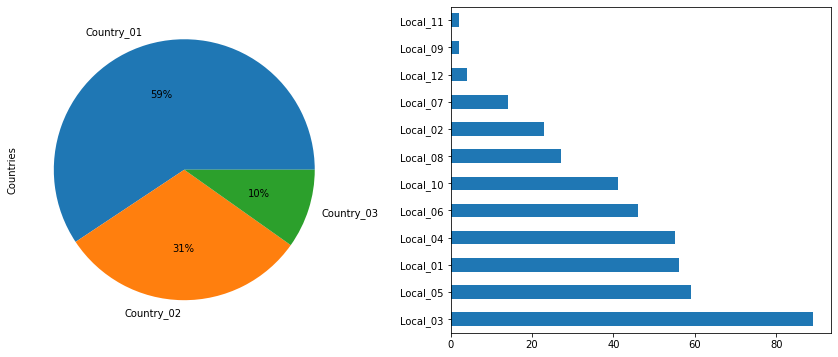

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
data['Countries'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = data['Countries'].unique(), figsize = (10, 6),ax=ax[0]);
data['Local'].value_counts().plot(kind = 'barh',  figsize = (15, 6),ax=ax[1]);
plt.show()

#### b) Explore distribution and possible co-relation between accidents and date

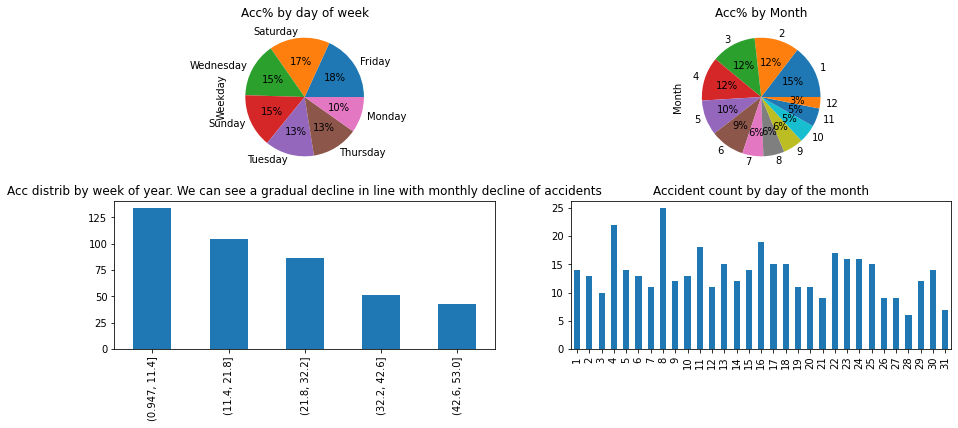

In [26]:
fig,axs = plt.subplots(2,2)
data['Month'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = data['Month'].unique(), figsize = (10, 6),ax=axs[0,1], title="Acc% by Month");
data['Weekday'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = data['Weekday'].unique(), figsize = (10, 6),ax=axs[0,0], title="Acc% by day of week");
data['WeekofYear'].value_counts(bins=5).plot(kind = 'bar',  figsize = (15, 6),ax=axs[1,0], title="Acc distrib by week of year. We can see a gradual decline in line with monthly decline of accidents");
data['Day'].value_counts().sort_index(ascending=True).plot(kind = 'bar',  figsize = (15, 6),ax=axs[1,1], title="Accident count by day of the month");
plt.show()

**Inferences from above two plots**

- We see a difference of 8% in accidents between Monday and Friday. This could be due to accidents caused due to workers hurrying to finish the job for the weekend.
- The accidents are most in the first *four* months and gradually decreases to half by July. By December, the number of accidents have fallen to 3% as compared to 15% in January (Evidenced also by week of year distribution)
- If we consider the sudden spike of accidents on the 4th and 8th day of the month as outliers, we can see a curve building-up to a peak mid-month before gradually receding.


***Explore reasoning behind country_01 having highest accidents (seen earlier)***

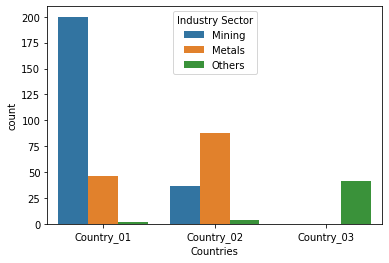

In [27]:
sns.countplot(x="Countries", data=data,hue="Industry Sector");

In [28]:
#Exclude string cols from dataframe to analyse for unique conts and freq
cols = list(set(data.columns.tolist())-set(['Date','Description']))
print(cols)

['Weekday', 'Countries', 'Potential Accident Level', 'Year', 'Month', 'Day', 'WeekofYear', 'Employee_Third_Party', 'Accident Level', 'Local', 'Gender', 'Critical Risk', 'Season', 'Industry Sector']


In [29]:
data[cols].describe(exclude=[np.number]).T

,count,unique,top,freq
Weekday,418,7,Thursday,76
Countries,418,3,Country_01,248
Potential Accident Level,418,6,IV,141
Employee_Third_Party,418,3,Third Party,185
Accident Level,418,5,I,309
Local,418,12,Local_03,89
Gender,418,2,Male,396
Critical Risk,418,33,Others,229
Season,418,4,Autumn,141
Industry Sector,418,3,Mining,237


***Inference***

Country_01 has the highest number of mining industry and 'Mining' contributes to nearly 50% of the accidents in the dataset. This could be the reason for the higher distribution of accidents in that country.

#### Other inferences on the dataset's distribution

- Accident Level I is the highest kind of accident accounting for 309 out of the 418 rows (73%)
- Male being the highest affected workers accounting for 396 out of 418 incidents. This is due to the nature of the industry sectors considered here being male dominated.
- More than 50% of the critical risk is categories as Others. Hence, a single point of failure is not evident.

#### c) Causality between time of the year and accidents

Eg: Winter months may lead to freezing of pipelines or stuck lines.Summer could lead to heat-strokes, rain could lead to flooding of mines, slipping etc...

In [30]:
#Observe count of all accident types by Month
monthly_trend = data.pivot_table(index='Month', columns=[ 'Year','Accident Level'], aggfunc='count')['Date']
monthly_trend.replace(np.nan,0,inplace=True)
#monthly accident counts pivot
monthly_trend.style.background_gradient()

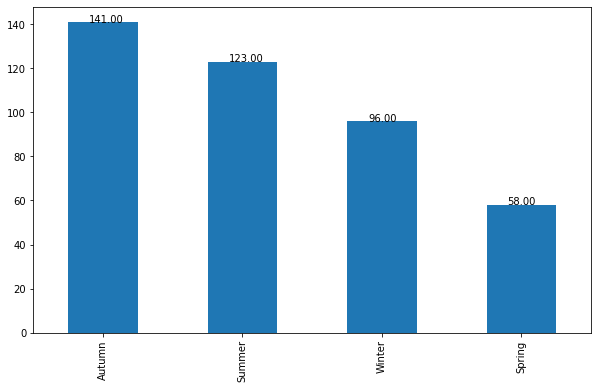

In [31]:
ax = data['Season'].value_counts().plot(kind = 'bar', figsize = (10, 6))

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.04))
plt.show()

### 3.3 Bivariate Analysis

In [32]:
data.columns

Index(['Date', 'Countries', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee_Third_Party',
       'Critical Risk', 'Description', 'Month', 'Day', 'Weekday', 'WeekofYear',
       'Year', 'Season'],
      dtype='object')

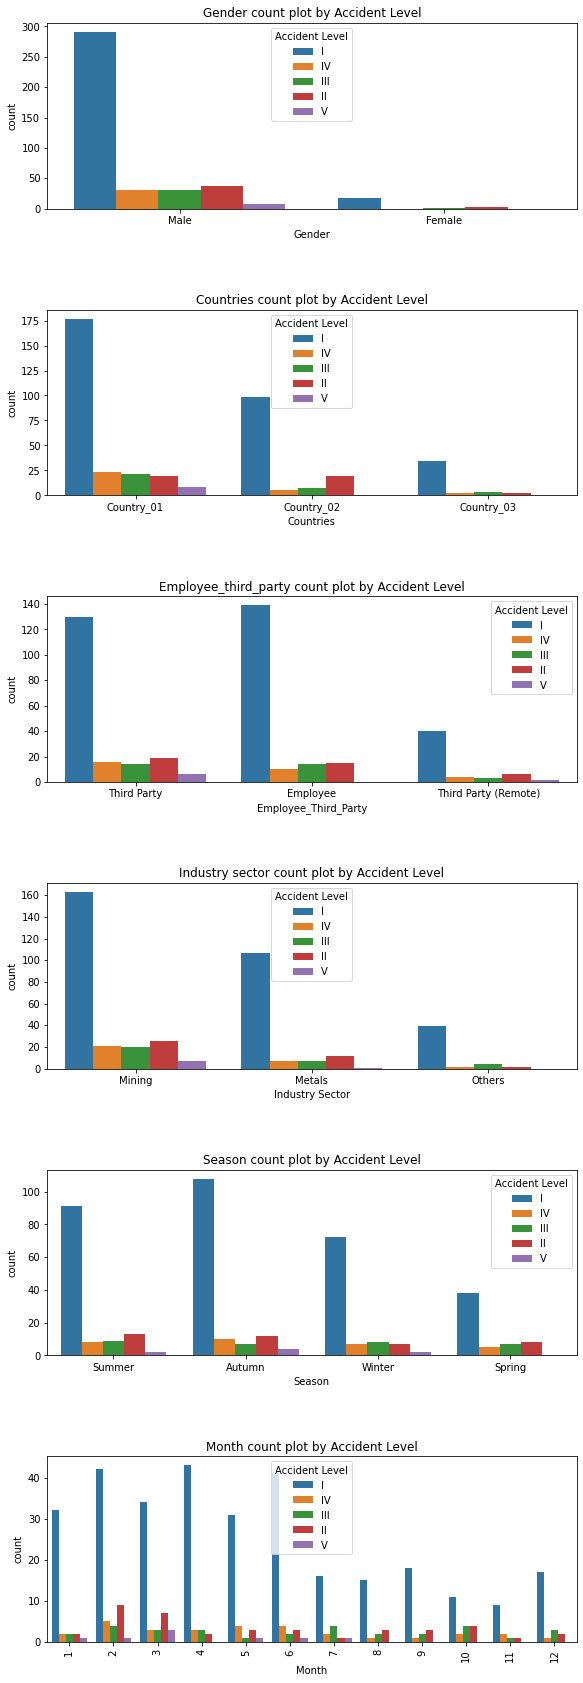

In [33]:
i = 0
columns = ['Gender','Countries','Employee_Third_Party','Industry Sector','Season','Month'] 
fig,axs = plt.subplots(6,1,figsize=(10,25))
fig.tight_layout(pad=8.0)
plt.xticks(rotation = 90)
for col in columns:
    labels = data[col].value_counts().index
    axs[i] = sns.countplot(x = col, data = data, ax = axs[i], orient = 'v',
                  hue = 'Accident Level').set_title(col.capitalize() +' count plot by Accident Level',fontsize=12)
    
    i = i+1
    
plt.show()

***Inferences***

Bivariate plots of columns 'Gender','Country','Employee_Third_Party','Industry_sector','Season','Month' w.r.t. Accident level shows that:

- Male has more number of accidents in accident level I.
- All countries have more accidents in Level I.
- All type of employess have accident level I as higher count.
- In all industry sectors,seasons and months accident level I as higher count.

In [34]:
critical_risk_pivot=data.pivot_table(index='Critical Risk', columns='Accident Level', aggfunc='count')['Month']
critical_risk_pivot.replace(np.nan, 0, inplace=True)
critical_risk_pivot['total']=critical_risk_pivot.sum(axis=1)

In [35]:
critical_risk_pivot.style.background_gradient()

Accident Level,I,II,III,IV,V,total
Critical Risk,,,,,,
Not applicable,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
Bees,10.000000,0.000000,0.000000,0.000000,0.000000,10.000000
Blocking and isolation of energies,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000
Burn,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
Chemical substances,15.000000,2.000000,0.000000,0.000000,0.000000,17.000000
Confined space,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Cut,11.000000,2.000000,1.000000,0.000000,0.000000,14.000000
Electrical Shock,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000
Electrical installation,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000


***Inference***

All accident levels have highest occurance under 'Others' critical risk category.

**Critical risks having atleast 10 occurences are**

    Bees, Projection, Chemical Substracnes, Pressed, Manual Tools, Cut, Venomous Animals

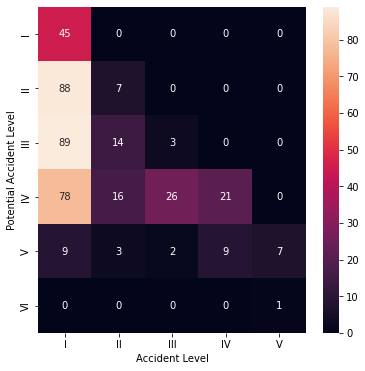

In [36]:
freq_matrix = pd.crosstab(data['Potential Accident Level'], data['Accident Level'])
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(freq_matrix, ax=ax, annot=True)

***Inferences***

Frequency is high for Accident Level 1 and Potential Accident Level 1,2,3,4

### 3.4 Multi-variate Analysis

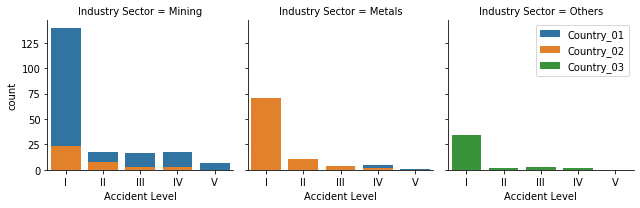

In [37]:
order={'I':1, 'II':2, 'III':3, 'IV':4, 'V':5}
grid = sns.FacetGrid(data, col = 'Industry Sector', hue='Countries', legend_out=True)
axis = grid.map(sns.countplot, 'Accident Level', order=order)
plt.legend(loc=1);

### 3.5 Analysis of Description

For the purposes of chat interface, description would be the main input from the user to assess risk.

Other, inputs can either be automatically retrieved such as date or asked from the user

Thus it is important to analyse the characteristics of the description

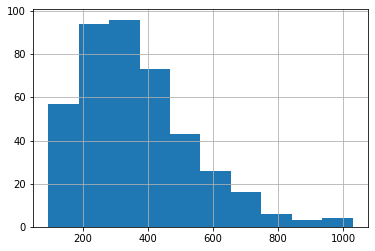

In [38]:
data['Description'].str.len().hist();

The majority length of the description falls between 200 to 400 words.

In [39]:
descriptions = "";
for d in data['Description']:
  descriptions = descriptions + d.lower()

In [40]:
# Get min and max length of descriptions
data['Length'] = data['Description'].str.len()

print('Minimum line length: {}'.format(data['Length'].min()))
print('Maximum line length: {}'.format(data['Length'].max()))

Minimum line length: 94
Maximum line length: 1029


# 4. NLP Pre-processing on Descriptions

In [41]:
!pip install contractions
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 284 kB 35.6 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
# Pipeline for text cleaning

def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

def tokenize(text):
    return nltk.word_tokenize(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def replace_numbers(words):
    """Replace all integer occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_numbers(words):
    """Remove all integer occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = ''
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


### 4.1 Normalize Description and Critical Risk Columns

By removing stopwords, convert to lowercase, remove-non-ascii words, replace numbers, remove punctuations.

In [43]:
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    #words = lemmetize_verbs(words)
    return words

In [44]:
def text_clean(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
data['Description'] = [text_clean(x) for x in data['Description']]

In [45]:
def text_clean(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
data['Critical Risk'] = [text_clean(x) for x in data['Critical Risk']]

### 4.2 Create Word-cloud of causes(action verbs) and nouns

In [46]:
# Concat all the oocurences of the descriptions
descriptions = "";
for d in data['Description']:
  descriptions = descriptions + d

In [47]:
#use only the tokenizer and tagger in Spacy's nlp pipeline
nlp = spacy.load("en_core_web_sm", disable=['parser', 'attribute_ruler', 'lemmatizer', 'ner'])

In [48]:
# Apply Spacy's nlp pipline to get pos tag
descp = nlp(descriptions) #Apply spacy nlp pipeline

In [49]:
# get a list of nouns and verbs
nouns = []; verbs=[];
for w in descp:
  if w.tag_ == 'NN':   #get the nouns
    nouns.append(w)
  elif w.tag_ == 'VB':  # get the action words(verbs)
    verbs.append(w)

In [50]:
print(len(verbs))
print(len(nouns))

165
6527


Generate word clouds to know the frequent occurring words among verbs, nouns. 

(To avoid clutter of stop-words, we are using a pre-processed text of descriptions)

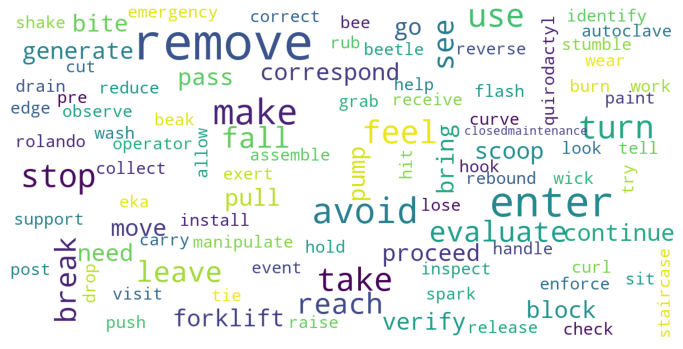

In [51]:
from wordcloud import WordCloud
wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
verbsCloud=wordcloud.generate(str(verbs))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(verbsCloud)
plt.show()

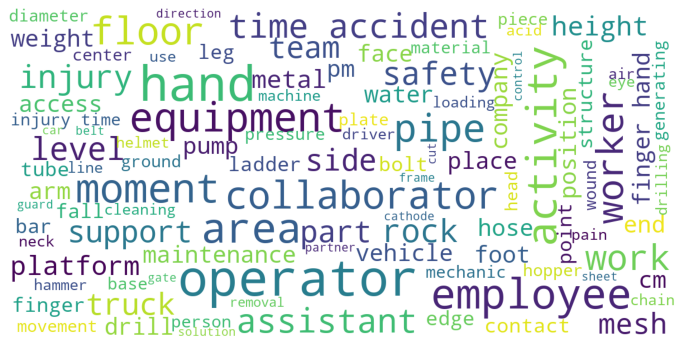

In [52]:
nounsCloud=wordcloud.generate(str(nouns))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(nounsCloud)
plt.show()

**Inference**

We see that the top causes are

`Removal, Fork-lift, Fall, Bite, reach, take etc`

The possible victims are 

`Operator, Assistant, Employee, Collaborator, Worker, Mechanic`

Most bodly-injuries happen to

`Hand, Finger, Neck, face`

Most accident-prone equipment/area are

`Truck, Drill, Pump, Ladder, Platform, Tube, Pipe, Mesh`

### 4.3 N-Grams Analysis

In [53]:
def top_ngrams (data, num):
  wc  = nltk.FreqDist(nltk.ngrams(data, num)).most_common(20) # taking top 20 most common words
  wc = pd.DataFrame(wc, columns=['Words', 'Count'])
  wc.Words = [' '.join(i) for i in wc.Words]
  wc.set_index('Words', inplace=True)       # setting the Words as index
  # Return dataframe containing unique tokens ordered by their counts 
  return wc

In [54]:
def get_words(spacy_doc):
  words =[]
  for t in spacy_doc:
    if len(t.text) > 3:
      words.append(t.text)
  return words

In [55]:
descp_tokens = get_words(descp)

In [56]:
uni_grams = top_ngrams(descp_tokens, 1)

# Words and counts
#uni_grams[0:20]

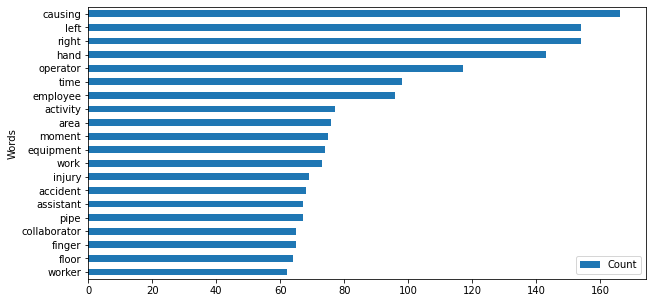

In [57]:
uni_grams.sort_values(by='Count').plot.barh(figsize = (10,5));

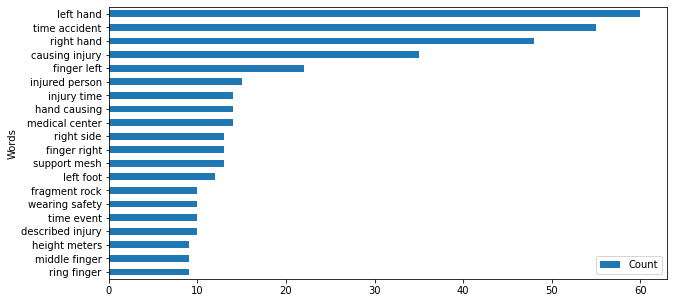

In [58]:
bi_grams = top_ngrams(descp_tokens, 2)
bi_grams.sort_values(by='Count').plot.barh(figsize = (10,5));
# Words and counts
#bi_grams[0:20]

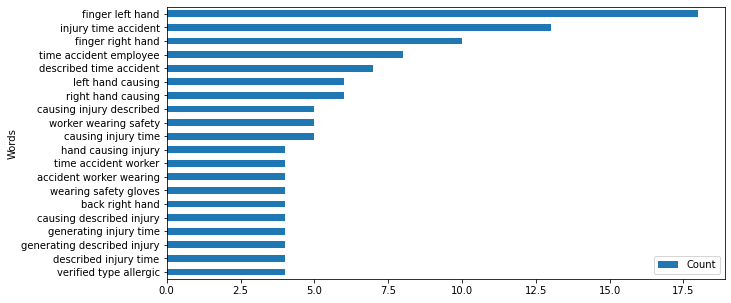

In [59]:
tri_grams = top_ngrams(descp_tokens, 3)
tri_grams.sort_values(by='Count').plot.barh(figsize = (10,5));
# Words and counts
#tri_grams[0:20]

# 5. Prepare data for model

## 5.1 Combine Description and Critical Risk columns

In [61]:
data['Desc'] = data['Description']+data['Critical Risk']

In [62]:
!pip install contractions
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

def tokenize(text):
    return nltk.word_tokenize(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = ''
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems



def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    #words = lemmetize_verbs(words)
    return words

In [64]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
data['Desc'] = [text_prepare(x) for x in data['Desc']]
le = LabelEncoder()
data['Accident Level'] = le.fit_transform(data['Accident Level'])

In [65]:
data.reset_index(drop=True, inplace=True)

## 5.2 Balance the data and save the cleaned, balanced text data to CSV

In [130]:
X = data[['Desc']]
y = data['Accident Level']

In [131]:
from imblearn.over_sampling import SMOTEN
over = SMOTEN(random_state=0)
X_text_b, y_text_b = over.fit_resample(X, y)

In [132]:
y_text_b.value_counts()

0    309
3    309
2    309
1    309
4    309
Name: Accident Level, dtype: int64

In [134]:
concatenated_data = pd.concat([X_text_b, y_text_b], axis=1)

In [135]:
concatenated_data.head()

,Desc,Accident Level
0,removing drill rod jumbo maintenance superviso...,0
1,activation sodium sulphide pump piping uncoupl...,0
2,substation milpo located level collaborator ex...,0
3,approximately nv cx695 ob7 personnel begins ta...,0
4,approximately circumstances mechanics anthony ...,3


In [125]:
concatenated_data.to_csv('cleaned_text_data.csv') 

## 5.3 Convert text to vectors, balance data and save to file

In [68]:
import imblearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X)
X_count_vect=vectorizer.transform(X)

In [70]:
over = SMOTE()
X_sm, y_sm = over.fit_resample(X_count_vect, y)

In [79]:
X_sm.toarray()
X_sm.shape

(1545, 3383)

In [126]:
y_sm_one_hot = pd.get_dummies(y_sm)

In [129]:
df_x = pd.DataFrame(X_sm.todense(), columns = vectorizer.get_feature_names())
df_final = pd.concat([df_x,y_sm_one_hot], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [128]:
df_final.shape

(1545, 3388)

In [244]:
df_final.to_csv("vectorized_data.csv")

## 5.4 Function to create a Glove embedding layer and prepare text sequences for tensorflow NN models

In [71]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-03-02 20:25:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-02 20:25:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-02 20:25:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [171]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    #dump tokenizer model for prediction later
    pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

In [222]:
## Helper methods for evaluation
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    cm = confusion_matrix(labels, preds)
    
    return {
        "mcc": mcc,
        "cm":cm
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# 6. Apply ML Models

## 6.1 Apply LSTM with Glove embedding layer

In [237]:
def build_lstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(LSTM(lstm_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [149]:
X_t = concatenated_data['Desc']
y_t = concatenated_data['Accident Level']

In [150]:
print(X_t.shape)
print(y_t.shape)

(1545,)
(1545,)


### a. Prepare inputs, split data and build model

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_lstm(word_index, embeddings_dict, 5)
model.summary()

Preparing model input ...
Found 3391 unique tokens.
(1545, 500)
Total 400000 word vectors.
Done!
Building Model!
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 50)           169600    
                                                                 
 lstm_20 (LSTM)              (None, 500, 32)           10624     
                                                                 
 dropout_20 (Dropout)        (None, 500, 32)           0         
                                                                 
 lstm_21 (LSTM)              (None, 500, 32)           8320      
                                                                 
 dropout_21 (Dropout)        (None, 500, 32)           0         
                                                                 
 lstm_22 (LSTM)              (None, 500, 32)           8320      
       

### b. Fit model

In [239]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=3,
                           batch_size=128,
                           verbose=1)

Epoch 1/3
10/10 [==============================] - 50s 4s/step - loss: 1.5777 - accuracy: 0.4005 - val_loss: 1.4719 - val_accuracy: 0.7735
Epoch 2/3
10/10 [==============================] - 30s 3s/step - loss: 1.3330 - accuracy: 0.7282 - val_loss: 0.9900 - val_accuracy: 0.7929
Epoch 3/3
10/10 [==============================] - 28s 3s/step - loss: 0.8758 - accuracy: 0.8058 - val_loss: 0.6231 - val_accuracy: 0.8188


### c. Evaluate model

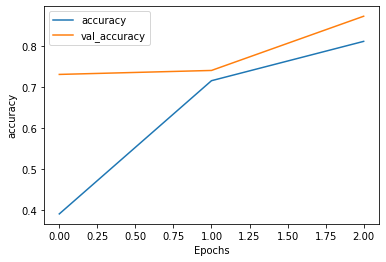

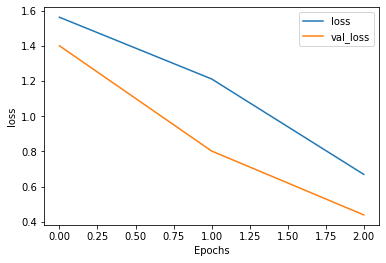

In [115]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       0.78      0.63      0.70        75
           1       0.87      0.95      0.91        56
           2       0.67      0.96      0.79        52
           3       0.96      0.80      0.88        66
           4       0.98      0.95      0.97        60

    accuracy                           0.84       309
   macro avg       0.85      0.86      0.85       309
weighted avg       0.86      0.84      0.84       309





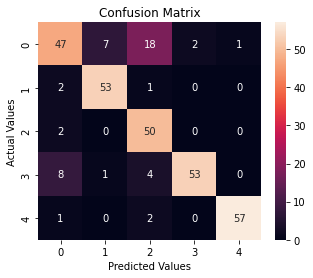

In [160]:
print("\n Evaluating Model ... \n")
predicted_x = model.predict(X_test_Glove)
predicted=np.argmax(predicted_x,axis=1)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
cm_df = pd.DataFrame(result['cm'],index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
# Confusion matrix is predicting values outside expected range
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### d. Save model

In [ ]:
!mkdir -p saved_models
model.save('saved_models/biLSTM')

## 6.2 Apply Statistical ML Models

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Read and setup data

In [266]:
data = pd.read_csv('vectorized_data.csv')

In [246]:
data.head()

,Unnamed: 0,02bp0166,02bp0167,02mx015mx010m,042tc06,06m,07m,080m,080mt,08fi0502,090m,100cm,10cm,10cmx8cm,10m,10x080x020,10x6x5cm,112gr,117m,11b,120mx110mx040m,12cm,12cmx10cmx3cm,12inch,13cmx6cmx2cm,140mt,14th,14x07x02,15cm,15m,15mx18m,160m,179th,18m,1cm,1m,1st,1tm,20cm,235m,...,workermechanic,workerothers,workers,working,workothers,workplace,workpressurized,works,workshop,worn,would,wound,wounding,wrench,wrist,x3,x32,x40cm,x6,xixas,xray,xrd,xxx,yaranga,ydrs,yields,yolk,young,z014,z132,z332,zaf,zamac,zero,zinc,zinco,zincsuspended,zn,zone,Accident Level
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3


In [247]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [267]:
X = data.drop(['Accident Level'],axis = 1)
y = data['Accident Level']
y_1h = pd.get_dummies(y)

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

### a1. Apply Logistic Regression 

In [271]:
logreg = LogisticRegression(solver = 'lbfgs')

logreg.fit(X_train, y_train)

y_pred_lr1 = logreg.predict(X_test)
logreg.score(X_train, y_train)
print('accuracy %s' % accuracy_score(y_pred_lr1, y_test))
print(classification_report(y_test, y_pred_lr1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy 0.8879310344827587
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        87
           1       0.86      0.87      0.87       103
           2       0.93      0.82      0.87        87
           3       0.91      0.91      0.91        90
           4       1.00      1.00      1.00        97

    accuracy                           0.89       464
   macro avg       0.89      0.89      0.89       464
weighted avg       0.89      0.89      0.89       464



### a2. Logistic Regression with Liblinear

In [273]:
logreg = LogisticRegression(solver = 'liblinear')

logreg.fit(X_train, y_train)

y_pred_lr2 = logreg.predict(X_test)
logreg.score(X_train, y_train)
print('accuracy %s' % accuracy_score(y_pred_lr2, y_test))
print(classification_report(y_test, y_pred_lr2))

accuracy 0.8922413793103449
              precision    recall  f1-score   support

           0       0.79      0.80      0.80        87
           1       0.82      0.87      0.85       103
           2       0.95      0.85      0.90        87
           3       0.92      0.92      0.92        90
           4       1.00      1.00      1.00        97

    accuracy                           0.89       464
   macro avg       0.90      0.89      0.89       464
weighted avg       0.89      0.89      0.89       464



### b. KNN Model

In [274]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
knn.score(X_train, y_train)
print(accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

0.915948275862069
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        87
           1       0.96      0.87      0.91       103
           2       1.00      0.87      0.93        87
           3       0.99      0.91      0.95        90
           4       1.00      0.98      0.99        97

    accuracy                           0.92       464
   macro avg       0.93      0.92      0.92       464
weighted avg       0.93      0.92      0.92       464



### c. Gaussian Naive Bayes

In [275]:
nb = GaussianNB()

nb.fit(X_train, y_train)

y_pred_nb = knn.predict(X_test)
nb.score(X_train, y_train)
print(accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

0.915948275862069
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        87
           1       0.96      0.87      0.91       103
           2       1.00      0.87      0.93        87
           3       0.99      0.91      0.95        90
           4       1.00      0.98      0.99        97

    accuracy                           0.92       464
   macro avg       0.93      0.92      0.92       464
weighted avg       0.93      0.92      0.92       464



### d. SVM
In its most basic type, SVM doesn't support multiclass classification. For multiclass classification, the same principle is utilized after breaking down the multi-classification problem into smaller subproblems, all of which are binary classification problems


In [276]:
svm = SVC(gamma=0.1, C=3)

svm.fit(X_train , y_train)

y_pred_svm = svm.predict(X_test)
svm.score(X_train, y_train)
print(accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

0.8642241379310345
              precision    recall  f1-score   support

           0       0.59      0.99      0.74        87
           1       1.00      0.86      0.93       103
           2       0.99      0.77      0.86        87
           3       0.99      0.84      0.91        90
           4       1.00      0.86      0.92        97

    accuracy                           0.86       464
   macro avg       0.91      0.86      0.87       464
weighted avg       0.92      0.86      0.88       464



### e. Decision Tree

In [277]:
dt = DecisionTreeClassifier(criterion='entropy', random_state = 1)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)
dt.score(X_test, y_test)

0.8987068965517241

If we allow the tree to grow to max extent, there will always be overfitting in the model due to which the test accuracy drops drastically.
Hence, we'll Regularize/prune the decision tree by limiting the max. depth of trees.

### f. Regularized / Pruned Decision Tree

In [280]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

In [281]:
dt_gs = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)
dt_gs.fit(X_train, y_train)
# print best parameter after tuning
print(dt_gs.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(dt_gs.best_estimator_)
#dt_pruned = DecisionTreeClassifier(criterion='entropy', max_depth = 100, random_state = 1)

dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth = 90, random_state = 1)
dt_pruned.fit(X_train, y_train)

{'criterion': 'gini', 'max_depth': 4}
DecisionTreeClassifier(max_depth=4)


DecisionTreeClassifier(max_depth=90, random_state=1)

In [282]:
y_pred_dt_pruned = dt_pruned.predict(X_test)
dt_pruned.score(X_train, y_train)
print(accuracy_score(y_test, y_pred_dt_pruned))
print(classification_report(y_test, y_pred_dt_pruned))

0.9137931034482759
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        87
           1       0.93      0.89      0.91       103
           2       0.97      0.89      0.93        87
           3       0.93      0.92      0.93        90
           4       1.00      0.98      0.99        97

    accuracy                           0.91       464
   macro avg       0.92      0.91      0.91       464
weighted avg       0.92      0.91      0.92       464



### g. Random Forest

In [283]:
rf = RandomForestClassifier()       #n_estimators = 50, max_depth =5, random_state=1)
rf = rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [284]:
rf.score(X_train, y_train)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

0.9073275862068966
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        87
           1       0.82      0.92      0.87       103
           2       0.94      0.93      0.94        87
           3       0.98      0.93      0.95        90
           4       1.00      1.00      1.00        97

    accuracy                           0.91       464
   macro avg       0.91      0.90      0.91       464
weighted avg       0.91      0.91      0.91       464



In [285]:
from scipy.stats import randint as sp_randint

In [286]:
param_dist = {"n_estimators": [10,50,100,150,200],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=n_iter_search)

In [287]:
rf_rs = random_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

In [288]:
# print best parameter after tuning
print(rf_rs.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(rf_rs.best_estimator_)

{'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
RandomForestClassifier(max_features=1, min_samples_split=8, n_estimators=200)


In [289]:
rf_rs = RandomForestClassifier(criterion= 'gini', max_features=6, min_samples_leaf=1, min_samples_split=6)

rf_rs = rf.fit(X_train, y_train)

y_pred_rf_rs = rf_rs.predict(X_test)

In [290]:
rf_rs.score(X_train, y_train)
print(accuracy_score(y_test, y_pred_rf_rs))
print(classification_report(y_test, y_pred_rf_rs))

0.9008620689655172
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        87
           1       0.81      0.91      0.86       103
           2       0.92      0.93      0.93        87
           3       0.99      0.92      0.95        90
           4       1.00      1.00      1.00        97

    accuracy                           0.90       464
   macro avg       0.90      0.90      0.90       464
weighted avg       0.90      0.90      0.90       464



### h. XGBoost

In [291]:
xgb = XGBClassifier() #n_estimators = 100, learning_rate = 0.1, random_state=1)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
acc_xgb  = accuracy_score(y_test, pred_xgb)
print("Train Score:"+str(xgb.score(X_train, y_train)))
print("Test SCore:"+xgb.score(X_test, y_test))

0.9267241379310345

# Under Contruction from Below

## 6.2 Apply NN model with one-hot encoding

In [231]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import  BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import L2

In [261]:
type(X)

pandas.core.frame.DataFrame

In [258]:
c = pd.concat([X,y_1h], axis=1)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y_1h, test_size = 0.2)

In [253]:
X_train.shape

(1236, 3383)

In [262]:
#param = 1e-9
param = 1e-4

# define the model
model = Sequential()

model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(param),
                kernel_constraint=unit_norm()))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(param), 
                kernel_constraint=unit_norm()))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax', kernel_regularizer=L2(param), 
                kernel_constraint=unit_norm())) # Multilabel

# compile the keras model
#opt = optimizers.Adamax(lr=0.01)
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

# Use earlystopping
callback = EarlyStopping(monitor='loss', patience=7, min_delta=1E-3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)


# fit the keras model on the dataset
training_history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


RuntimeError: ignored

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# 7. Prediction function for sequence models

In [209]:
def prepare_text_for_predict(text, tokenizer, MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
  np.random.seed(7)
  sequences = tokenizer.texts_to_sequences(text)
  text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  return text


In [220]:
def predict_with_trained_model(model, tokenizer, text):
  text_seq = prepare_text_for_predict(text,tokenizer)
  pred = model.predict(text_seq[:1])
  prediction=np.argmax(pred,axis=1)
  return prediction

In [162]:
X_test_Glove.shape

(309, 500)

In [174]:
with open('text_tokenizer.pkl', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [180]:
data['Desc'][0]

'removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic supports one end drill equipment pull hands bar accelerate removal moment bar slides point support tightens fingers mechanic drilling bar beam jumbopressed'

In [225]:
i = 25
prediction = predict_with_trained_model(model, loaded_tokenizer, data['Desc'][i])
#y = data['Accident Level'][i]
#print(t, y)
## why is it coming as [3,3,3,3,3....]  ...something wrong with model?
#TODO
## Random testing for predcition is always producing result 3 and output is coming 0 .... Take other values and test

In [ ]:
predicted_x = model.predict(X_test_Glove)

#References for using Glove embeddings for accident level prediction:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/



In [ ]:
#https://github.com/golamSaroar/h2o-autoML/blob/master/h2o-automl.ipynb
